This notebook reads data from the `out` folder and visualizes the results of the JoularJX .csv files with matplotlib and seaborn.

First, we import the necessary libraries.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

We want to read all joularjx-*-filtered-methods-energy.csv from the `out` folder and its subfolders named with a timestamp.

In [37]:
out_folder = 'out'
# List all .csv files in the out folder and its subfolders
csv_files = []
for root, dirs, files in os.walk(out_folder):
    for file in files:
        if file.endswith('-filtered-methods-energy.csv'):
            csv_files.append(os.path.relpath(os.path.join(root, file), out_folder)) # Store relative path to out_folder
print(f'Found {len(csv_files)} .csv files:')
for f in csv_files:
    print(f)

Found 20 .csv files:
2025-09-25_09-09-59-Java-24.0.2-tem-Spring-Boot-3.5.6/joularJX-29875-filtered-methods-energy.csv
2025-09-25_09-09-59-Java-24.0.2-tem-Spring-Boot-3.5.6/joularJX-29904-filtered-methods-energy.csv
2025-09-25_09-09-59-Java-24.0.2-tem-Spring-Boot-3.5.6/joularJX-29975-filtered-methods-energy.csv
2025-09-25_09-09-59-Java-24.0.2-tem-Spring-Boot-3.5.6/joularJX-29935-filtered-methods-energy.csv
2025-09-25_09-00-27-Java-24.0.2-tem-Spring-Boot-3.5.6/joularJX-16422-filtered-methods-energy.csv
2025-09-25_09-00-27-Java-24.0.2-tem-Spring-Boot-3.5.6/joularJX-16574-filtered-methods-energy.csv
2025-09-25_09-00-27-Java-24.0.2-tem-Spring-Boot-3.5.6/joularJX-16518-filtered-methods-energy.csv
2025-09-25_09-00-27-Java-24.0.2-tem-Spring-Boot-3.5.6/joularJX-16460-filtered-methods-energy.csv
2025-09-25_09-19-39-Java-24.0.2-tem-Spring-Boot-3.5.6/joularJX-43219-filtered-methods-energy.csv
2025-09-25_09-19-39-Java-24.0.2-tem-Spring-Boot-3.5.6/joularJX-43259-filtered-methods-energy.csv
2025-09-2

The `out` folder contains the results of five test executions.
Each test execution generates a subdirectory named with a unique identifier, containing multiple .csv files, one for each LakesideMutual service.

1. customer-core
2. customer-management
3. customer-self-service
4. policy-management

We want to store all the data in a dictionary of pandas DataFrames, where the first level key is the test run identifier, and the second level key is the service name.
The value is a pandas DataFrame containing the method names and their corresponding energy consumption.

In [38]:
# Extract unique test run from the file paths
test_runs = set()
for csv_file in csv_files:
    test_run_identifier = csv_file.split(os.sep)[0] # Assuming the first part of the path is the test run identifier
    test_runs.add(test_run_identifier)
print(f'Found {len(test_runs)} unique test run identifiers:')
for t in test_runs:
    print(t)
# Create a dictionary to hold DataFrames for each test run
data_by_test_run = {test_run: {} for test_run in test_runs}

Found 5 unique test run identifiers:
2025-09-25_09-00-27-Java-24.0.2-tem-Spring-Boot-3.5.6
2025-09-25_09-38-50-Java-24.0.2-tem-Spring-Boot-3.5.6
2025-09-25_09-19-39-Java-24.0.2-tem-Spring-Boot-3.5.6
2025-09-25_09-29-14-Java-24.0.2-tem-Spring-Boot-3.5.6
2025-09-25_09-09-59-Java-24.0.2-tem-Spring-Boot-3.5.6




The generated files are named as follows: joularjx-\<id\>-filtered-methods-energy.csv, where \<id>\ is a generated joularjx id.
Each .csv file has two columns, the first column contains method names in the format com.lakesidemutual.\<servicename\>.interfaces.\<class\>.\<method\> and the second column contains the total energy consumption in Joules for that method.
Each row represents a method and the energy consumption for its execution.

We want to read all joularjx-\<id\>-filtered-methods-energy.csv from the `out/<test-run-identifier>` folders, then access the first column to extract the service name and the method name, and the second column to access the energy consumption.
The delimiter in the .csv files is a comma.
We store the data in a two level dictionary, where the first level key is the service name and the second level key is the method name, and the value is the energy consumption for that method.

In [39]:
# Read each folder in data_by_test_run and add another dictionary for each service
for test_run in data_by_test_run.keys():
    # List all .csv files in the out/<test_run> folder
    test_run_folder = os.path.join(out_folder, test_run)
    test_run_csv_files = [f for f in os.listdir(test_run_folder) if f.endswith('-filtered-methods-energy.csv')]

    for csv_file in test_run_csv_files:
        file_path = os.path.join(test_run_folder, csv_file) # Full path to the .csv file
        # try and catch any error reading the file
        try:
            df = pd.read_csv(file_path, header=None) # Read the .csv file without header
        except pd.errors.EmptyDataError:
            print(f'Skipping empty file: {csv_file} in test run: {test_run}')
            continue
        except Exception as e:
            print(f'Error reading file {csv_file} in test run {test_run}: {e}')
            continue
        if df.empty:
            print(f'Skipping empty file: {csv_file} in test run: {test_run}')
            continue

        # Extract service name from the first column
        service_name = df.iloc[0, 0].split('.')[2] # Assuming the service name is the second part of the method name

        # Extract method name + energy consumption
        df_extracted = pd.DataFrame({
            'Method': df.iloc[:, 0].apply(lambda x: x.split('.')[-1]), # Assuming the method name is the last part of the string
            'Energy': df.iloc[:, 1]
        })

        # Initialize dict for this test run if needed
        if service_name not in data_by_test_run[test_run]:
            data_by_test_run[test_run][service_name] = df_extracted.copy()
        else:
            data_by_test_run[test_run][service_name] = pd.concat(
                [data_by_test_run[test_run][service_name], df_extracted],
                ignore_index=True
            )

# Display the test run identifiers and the services found in each test run
print('DataFrames created for the following test runs and services:')
for test_run, services in data_by_test_run.items():
    print(f'Test Run: {test_run}')
    for service, df in services.items():
        print(f'  Service: {service}, Number of methods: {len(df)}')
        display(df)

Skipping empty file: joularJX-16460-filtered-methods-energy.csv in test run: 2025-09-25_09-00-27-Java-24.0.2-tem-Spring-Boot-3.5.6
Skipping empty file: joularJX-70487-filtered-methods-energy.csv in test run: 2025-09-25_09-38-50-Java-24.0.2-tem-Spring-Boot-3.5.6
Skipping empty file: joularJX-43188-filtered-methods-energy.csv in test run: 2025-09-25_09-19-39-Java-24.0.2-tem-Spring-Boot-3.5.6
Skipping empty file: joularJX-56388-filtered-methods-energy.csv in test run: 2025-09-25_09-29-14-Java-24.0.2-tem-Spring-Boot-3.5.6
Skipping empty file: joularJX-29904-filtered-methods-energy.csv in test run: 2025-09-25_09-09-59-Java-24.0.2-tem-Spring-Boot-3.5.6
DataFrames created for the following test runs and services:
Test Run: 2025-09-25_09-00-27-Java-24.0.2-tem-Spring-Boot-3.5.6
  Service: customercore, Number of methods: 7


,Method,Energy
0,setCallbacks,0.1045
1,getCustomer,468.4010
2,changeAddress,2.4983
3,<init>,0.3487
4,<clinit>,0.2416
5,getIncludedFields,0.3170
6,createCustomerResponseDto,60.8365


  Service: policymanagement, Number of methods: 9


,Method,Energy
0,createPolicyDto,458.3845
1,getPolicies,429.4666
2,getInsuranceQuoteRequests,7628.6145
3,<init>,0.0468
4,getInsuranceQuoteRequest,46.0574
5,getPolicy,12.8814
6,respondToInsuranceQuoteRequest,172.4298
7,lambda$getPolicies$0,0.1474
8,apply,4.8232


  Service: customerselfservice, Number of methods: 12


,Method,Energy
0,apply,6.9266
1,setCallbacks,0.0102
2,getInsuranceQuoteRequest,16.8468
3,addHATEOASLinks,12.0496
4,getCustomer,198.5017
5,getInsuranceQuoteRequests,13361.8582
6,respondToInsuranceQuote,62.2426
7,changeAddress,0.0770
8,authenticationRequest,58.6242
9,createInsuranceQuoteRequest,182.7490


Test Run: 2025-09-25_09-38-50-Java-24.0.2-tem-Spring-Boot-3.5.6
  Service: customerselfservice, Number of methods: 11


,Method,Energy
0,setCallbacks,0.0678
1,authenticationRequest,50.9899
2,createInsuranceQuoteRequest,176.0536
3,getInsuranceQuoteRequest,16.7686
4,getCurrentUser,15.3181
5,addHATEOASLinks,9.8196
6,apply,7.0457
7,getCustomer,201.4998
8,getInsuranceQuoteRequests,14129.4205
9,respondToInsuranceQuote,56.2429


  Service: policymanagement, Number of methods: 7


,Method,Energy
0,createPolicyDto,593.8472
1,getPolicies,585.5799
2,getInsuranceQuoteRequests,7562.5465
3,getInsuranceQuoteRequest,46.9694
4,getPolicy,12.7698
5,apply,5.5873
6,respondToInsuranceQuoteRequest,179.3089


  Service: customercore, Number of methods: 5


,Method,Energy
0,getCustomer,470.6971
1,changeAddress,2.3446
2,<init>,0.0540
3,getIncludedFields,0.5002
4,createCustomerResponseDto,57.1045


Test Run: 2025-09-25_09-19-39-Java-24.0.2-tem-Spring-Boot-3.5.6
  Service: customerselfservice, Number of methods: 11


,Method,Energy
0,setCallbacks,0.0291
1,authenticationRequest,67.2896
2,createInsuranceQuoteRequest,259.2696
3,getInsuranceQuoteRequest,16.2830
4,getCurrentUser,12.7185
5,apply,6.7959
6,addHATEOASLinks,11.0414
7,getCustomer,216.0186
8,getInsuranceQuoteRequests,13764.0090
9,respondToInsuranceQuote,94.0519


  Service: policymanagement, Number of methods: 8


,Method,Energy
0,createPolicyDto,463.4840
1,getPolicies,462.4943
2,getInsuranceQuoteRequests,7707.3599
3,getPolicy,10.3234
4,getInsuranceQuoteRequest,44.2937
5,respondToInsuranceQuoteRequest,271.5412
6,apply,3.0163
7,<init>,0.1715


  Service: customercore, Number of methods: 3


,Method,Energy
0,getCustomer,492.9504
1,changeAddress,4.0738
2,createCustomerResponseDto,62.6560


Test Run: 2025-09-25_09-29-14-Java-24.0.2-tem-Spring-Boot-3.5.6
  Service: customercore, Number of methods: 5


,Method,Energy
0,<init>,116.1956
1,getCustomer,478.0752
2,changeAddress,3.1498
3,getIncludedFields,0.7983
4,createCustomerResponseDto,56.4798


  Service: customerselfservice, Number of methods: 11


,Method,Energy
0,authenticationRequest,77.9902
1,createInsuranceQuoteRequest,151.8969
2,getInsuranceQuoteRequest,14.9828
3,getCurrentUser,13.8462
4,CGLIB$STATICHOOK61,135.0050
5,addHATEOASLinks,12.7860
6,getCustomer,192.0685
7,getInsuranceQuoteRequests,13613.5568
8,respondToInsuranceQuote,51.0500
9,apply,7.8605


  Service: policymanagement, Number of methods: 7


,Method,Energy
0,createPolicyDto,366.4071
1,getPolicies,356.7970
2,getInsuranceQuoteRequests,7802.9905
3,getInsuranceQuoteRequest,44.4972
4,getPolicy,8.2945
5,respondToInsuranceQuoteRequest,183.1835
6,apply,3.6724


Test Run: 2025-09-25_09-09-59-Java-24.0.2-tem-Spring-Boot-3.5.6
  Service: customercore, Number of methods: 3


,Method,Energy
0,getCustomer,489.9832
1,changeAddress,2.7274
2,createCustomerResponseDto,48.2429


  Service: policymanagement, Number of methods: 7


,Method,Energy
0,createPolicyDto,388.2684
1,getPolicies,404.8133
2,getInsuranceQuoteRequests,7582.4960
3,getInsuranceQuoteRequest,47.2956
4,getPolicy,9.2892
5,respondToInsuranceQuoteRequest,177.7704
6,apply,5.7896


  Service: customerselfservice, Number of methods: 10


,Method,Energy
0,authenticationRequest,42.3096
1,apply,7.8637
2,createInsuranceQuoteRequest,158.7369
3,getInsuranceQuoteRequest,15.9269
4,getCurrentUser,14.6749
5,addHATEOASLinks,10.6026
6,getCustomer,203.4745
7,getInsuranceQuoteRequests,13509.6848
8,respondToInsuranceQuote,71.9999
9,changeAddress,0.1399


We want to visualize the energy consumption for the entire application in a boxplot.
The energy consumption of each test run is aggregated by summing the energy consumption of all methods in all services.

In [40]:
# Collect results in a list instead of concatenating repeatedly to evade errors
rows = []
for test_run, services in data_by_test_run.items():
    total_energy = 0
    for service, df in services.items():
        total_energy += df['Energy'].sum()
    rows.append({'Test Run': test_run, 'Total Energy': total_energy})
# Build the DataFrame once
total_energy_by_test_run = pd.DataFrame(rows, columns=['Test Run', 'Total Energy'])
# Display the total energy consumption for each test run
print('Total energy consumption for each test run:')
display(total_energy_by_test_run)


Total energy consumption for each test run:


,Test Run,Total Energy
0,2025-09-25_09-00-27-Java-24.0.2-tem-Spring-Boo...,23316.8863
1,2025-09-25_09-38-50-Java-24.0.2-tem-Spring-Boo...,24181.0319
2,2025-09-25_09-19-39-Java-24.0.2-tem-Spring-Boo...,23970.3348
3,2025-09-25_09-29-14-Java-24.0.2-tem-Spring-Boo...,23691.6861
4,2025-09-25_09-09-59-Java-24.0.2-tem-Spring-Boo...,23192.0897


Now we want to visualize the total energy consumption using a boxplot.
Each record in total_energy_by_test_run should be represented as a point in the boxplot.

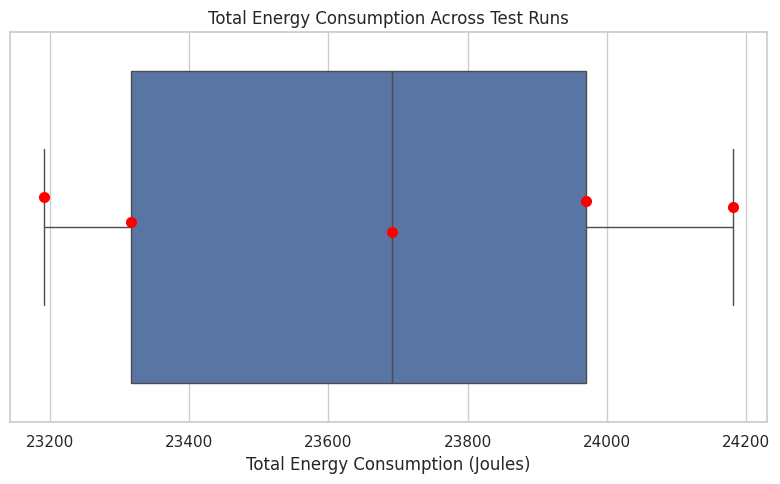

In [41]:
# Set the style for seaborn
sns.set(style="whitegrid")
# Create a box plot for total energy consumption across test runs
plt.figure(figsize=(8, 5))
sns.boxplot(x='Total Energy', data=total_energy_by_test_run, orient='horizontal')
sns.stripplot(x='Total Energy', data=total_energy_by_test_run, color='red', size=8, jitter=True, orient='horizontal')
plt.title('Total Energy Consumption Across Test Runs')
plt.xlabel('Total Energy Consumption (Joules)')
plt.tight_layout()
plt.show()

Now we want to visualize the energy consumption for each service in a boxplot.
The energy consumption of each service is aggregated by summing the energy consumption of all methods in that service.
Again, each record should be represented as a point in the boxplot.

Total energy consumption for each service:


,Test Run,Service,Total Energy
0,2025-09-25_09-00-27-Java-24.0.2-tem-Spring-Boo...,customercore,532.7476
1,2025-09-25_09-00-27-Java-24.0.2-tem-Spring-Boo...,policymanagement,8752.8516
2,2025-09-25_09-00-27-Java-24.0.2-tem-Spring-Boo...,customerselfservice,14031.2871
3,2025-09-25_09-38-50-Java-24.0.2-tem-Spring-Boo...,customerselfservice,14663.7225
4,2025-09-25_09-38-50-Java-24.0.2-tem-Spring-Boo...,policymanagement,8986.6090
5,2025-09-25_09-38-50-Java-24.0.2-tem-Spring-Boo...,customercore,530.7004
6,2025-09-25_09-19-39-Java-24.0.2-tem-Spring-Boo...,customerselfservice,14447.9703
7,2025-09-25_09-19-39-Java-24.0.2-tem-Spring-Boo...,policymanagement,8962.6843
8,2025-09-25_09-19-39-Java-24.0.2-tem-Spring-Boo...,customercore,559.6802
9,2025-09-25_09-29-14-Java-24.0.2-tem-Spring-Boo...,customercore,654.6987


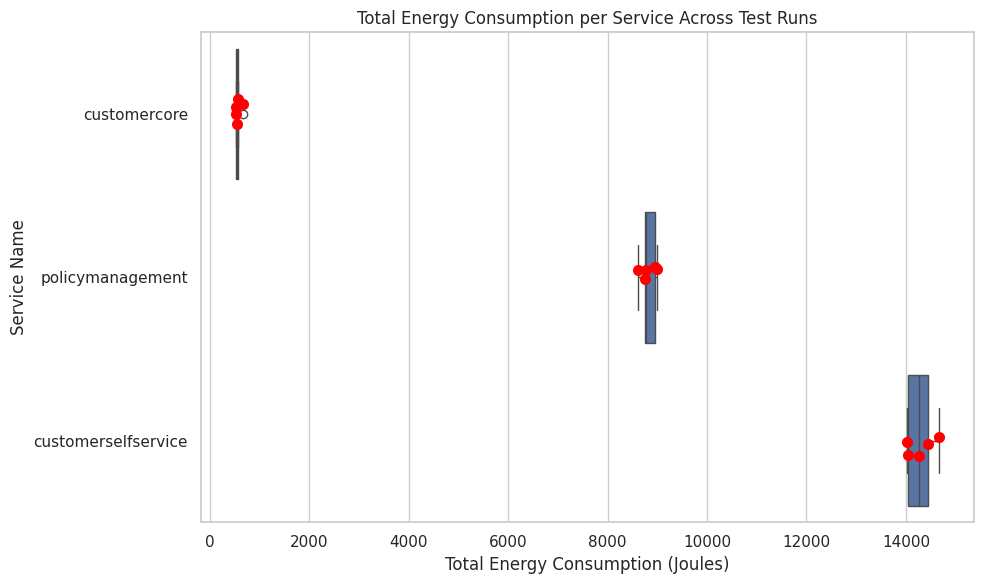

In [49]:
# Collect results in a list instead of concatenating repeatedly to evade errors
rows = []
for test_run, services in data_by_test_run.items():
    for service, df in services.items():
        total_energy = df['Energy'].sum()
        rows.append({'Test Run': test_run, 'Service': service, 'Total Energy': total_energy})
# Build the DataFrame once
total_energy_by_service = pd.DataFrame(rows, columns=['Test Run', 'Service', 'Total Energy'])
# Display the total energy consumption for each service
print('Total energy consumption for each service:')
display(total_energy_by_service)

# Create a box plot for total energy consumption per service across test runs
plt.figure(figsize=(10, 6))
sns.boxplot(x='Total Energy', y='Service', data=total_energy_by_service, orient='h')
sns.stripplot(x='Total Energy', y='Service', data=total_energy_by_service, color='red', size=8, jitter=True, orient='h')
plt.title('Total Energy Consumption per Service Across Test Runs')
plt.xlabel('Total Energy Consumption (Joules)')
plt.ylabel('Service Name')
plt.tight_layout()
plt.show()


Now we have a dictionary of dictionaries of DataFrames.
We want to aggregate the energy consumption for each method across all test runs and calculate the average energy consumption.
We create a new dictionary of DataFrames, where the key is the service name and the value is a DataFrame containing the method names and their corresponding total energy consumption across all test runs.

In [42]:
# Create a dictionary to hold aggregated DataFrames for each service
average_method_energy_by_service = {}
for test_run, services in data_by_test_run.items():
    for service, df in services.items():
        if service not in average_method_energy_by_service:
            average_method_energy_by_service[service] = df.copy()   # directly assign first DataFrame
        else:
            # Concatenate and aggregate by method name
            average_method_energy_by_service[service] = pd.concat([average_method_energy_by_service[service], df], ignore_index=True)
            average_method_energy_by_service[service] = average_method_energy_by_service[service].groupby('Method', as_index=False).mean(numeric_only=True)

# Display the aggregated DataFrames and all methods for each service
print('Aggregated DataFrames for each service:')
for service, df in average_method_energy_by_service.items():
    print(f'Service: {service}, Number of methods: {len(df)}')
    display(df)

Aggregated DataFrames for each service:
Service: customercore, Number of methods: 7


,Method,Energy
0,<clinit>,0.241600
1,<init>,58.198475
2,changeAddress,2.963056
3,createCustomerResponseDto,53.444712
4,getCustomer,484.822831
5,getIncludedFields,0.603450
6,setCallbacks,0.104500


Service: policymanagement, Number of methods: 9


,Method,Energy
0,<init>,0.109150
1,apply,4.840594
2,createPolicyDto,409.435956
3,getInsuranceQuoteRequest,46.122988
4,getInsuranceQuoteRequests,7654.863175
5,getPolicies,412.858094
6,getPolicy,9.611850
7,lambda$getPolicies$0,0.147400
8,respondToInsuranceQuoteRequest,190.607394


Service: customerselfservice, Number of methods: 13


,Method,Energy
0,CGLIB$STATICHOOK61,135.005000
1,CGLIB$STATICHOOK63,116.181300
2,addHATEOASLinks,11.244800
3,apply,7.619731
4,authenticationRequest,55.914431
5,changeAddress,0.189300
6,createInsuranceQuoteRequest,172.176537
7,getCurrentUser,14.297438
8,getCustomer,201.756794
9,getInsuranceQuoteRequest,15.845487


Now we want to visualize the average energy consumption for each method in each service using a grouped bar chart.
The horizontal axis represents the energy consumption in Joules, and the vertical axis represents the method names.

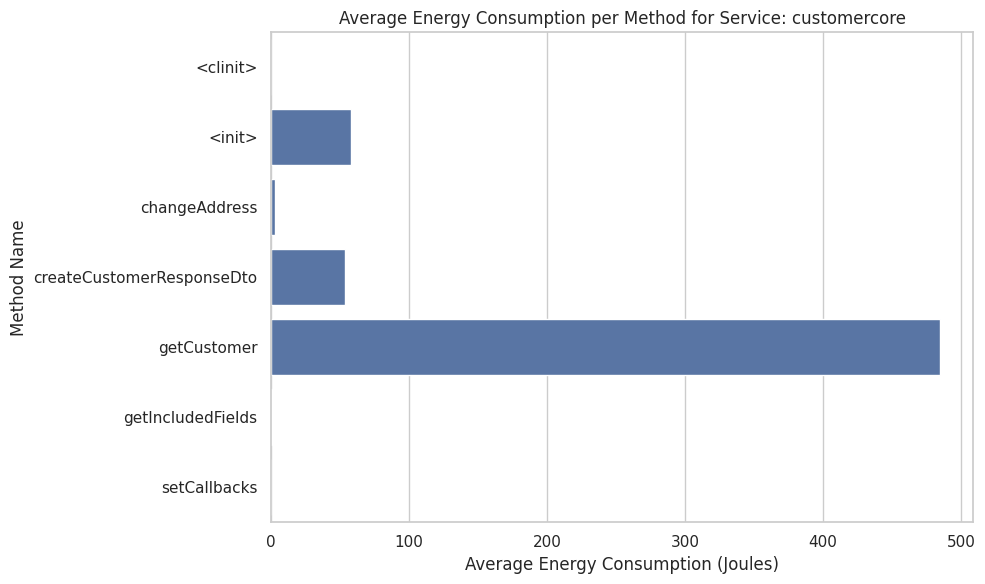

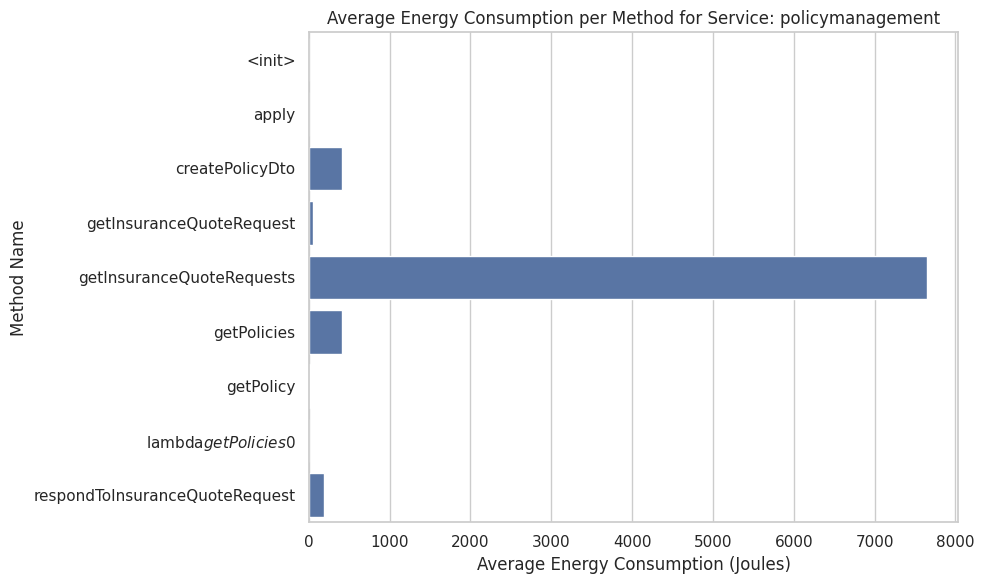

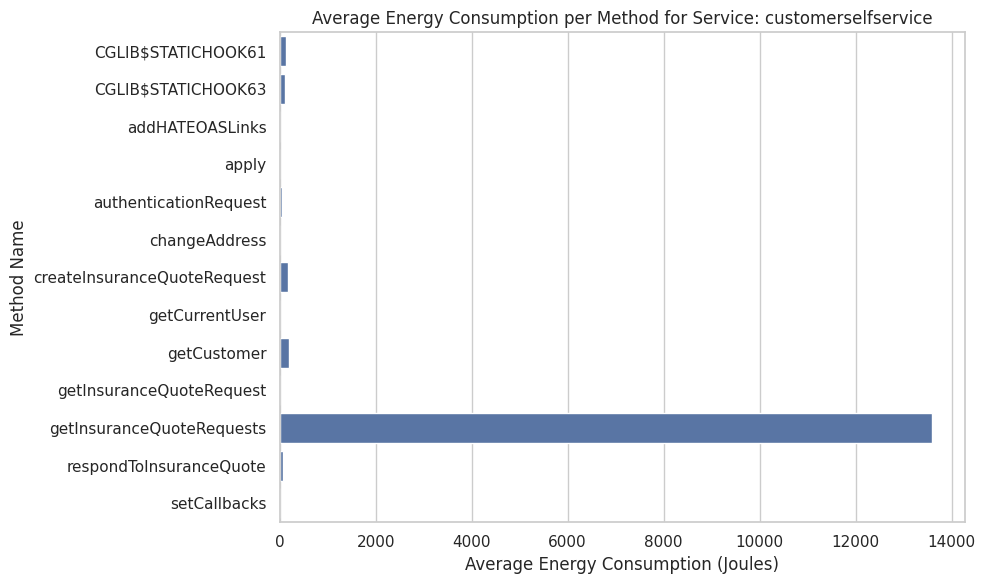

In [43]:
# Set the style for seaborn
sns.set(style="whitegrid")
# Create a bar plot for each service
for service, df in average_method_energy_by_service.items():
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Energy', y='Method', data=df)
    plt.title(f'Average Energy Consumption per Method for Service: {service}')
    plt.xlabel('Average Energy Consumption (Joules)')
    plt.ylabel('Method Name')
    plt.tight_layout()
    plt.show()

Now we want to calculate the average energy consumption for each service across all test runs.
We create a new DataFrame, where the index is the service name and the value is the average energy consumption for that service.

In [44]:
# Collect results in a list instead of concatenating repeatedly to evade errors
rows = []

for service, df in average_method_energy_by_service.items():
    # Sum the already-averaged method energies to get per-service total
    total_energy = df['Energy'].sum()
    rows.append({'Service': service, 'Energy': total_energy})

# Build the DataFrame once
average_energy_by_service = pd.DataFrame(rows, columns=['Service', 'Energy'])

# Display the average energy consumption for each service
print('Average energy consumption for each service:')
display(average_energy_by_service)

Average energy consumption for each service:


,Service,Energy
0,customercore,600.378625
1,policymanagement,8728.596600
2,customerselfservice,14395.126794


Now we want to visualize the average energy consumption for each service using a bar chart.
The horizontal axis represents the energy consumption in Joules, and the vertical axis represents the service names.

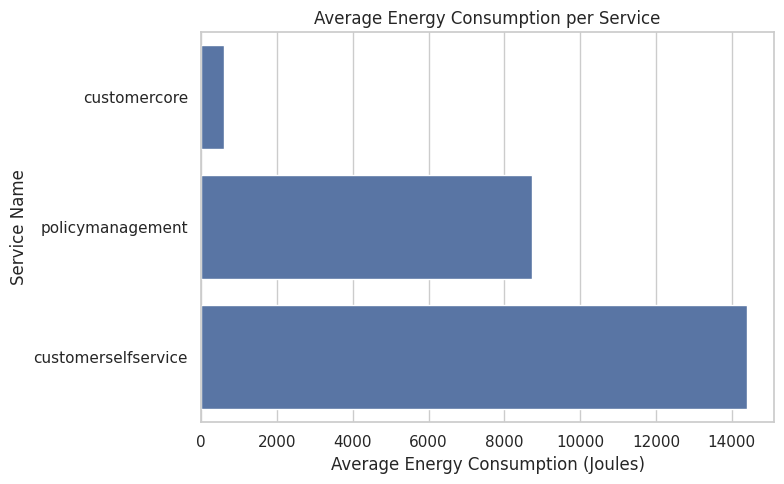

In [45]:
# Create a bar plot for average energy consumption per service
plt.figure(figsize=(8, 5))
sns.barplot(x='Energy', y='Service', data=average_energy_by_service)
plt.title('Average Energy Consumption per Service')
plt.xlabel('Average Energy Consumption (Joules)')
plt.ylabel('Service Name')
plt.tight_layout()
plt.show()

Now we want to aggregate the energy consumption for the entire application by summing the average energy consumption for each service.

In [46]:
# Calculate the total average energy consumption for the entire application
total_average_energy = average_energy_by_service['Energy'].sum()
print(f'Total average energy consumption for the entire application: {total_average_energy:.2f} Joules')

Total average energy consumption for the entire application: 23724.10 Joules


Now we want to visualize the total average energy consumption for the entire application using a single bar chart.
The horizontal axis represents the energy consumption in Joules, and the vertical axis represents the application name.

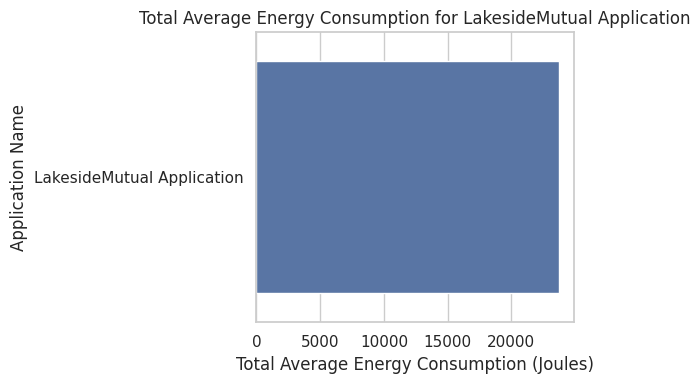

In [47]:
# Create a bar plot for total average energy consumption for the entire application
plt.figure(figsize=(6, 4))
sns.barplot(x=[total_average_energy], y=['LakesideMutual Application'])
plt.title('Total Average Energy Consumption for LakesideMutual Application')
plt.xlabel('Total Average Energy Consumption (Joules)')
plt.ylabel('Application Name')
plt.tight_layout()
plt.show()